In [28]:
try:
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score

!pip install biosppy
import biosppy as biosppy

!pip install PyWavelets
import pywt

from sklearn.preprocessing import normalize

from scipy import stats
from statistics import pstdev,variance

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [29]:
X = pd.read_csv('X_train.csv', float_precision='high').drop('id', axis=1)
y = pd.read_csv('y_train.csv', float_precision='high').drop('id', axis=1)

dataset_x = np.array(X)
dataset_y = np.array(y)

In [30]:
print(dataset_x.shape)
print(dataset_y.shape)

(5117, 17807)
(5117, 1)


In [31]:
dataset_x[0]

array([-13.,  -9.,  -6., ...,  nan,  nan,  nan])

In [32]:
# FFT, power, average and autocorrelation
a = dataset_x

autocorr = []
ptp = []
avg = []
fft=[]

for i in range(len(a)):

    h = a[i]
    h = h[~np.isnan(h)]

    h_series = pd.Series(h)
    corr = h_series.autocorr(lag=2)
    autocorr.append(corr)

    avg.append(np.average(h))
    ptp.append(np.ptp(h))
    
    #fourier transform, the largest 15 fft
    f = np.fft.fft(h)
    array = f[0:800]
    n = 15
    indices = array.argsort()[-n:][::-1]
    fft.append(indices)

print(len(autocorr))
new_autocorr = np.transpose(np.array([autocorr]))
print(new_autocorr.shape)
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft_np = np.array(fft)
print(fft_np.shape)

5117
(5117, 1)
(5117, 15)


In [33]:
#Padding the sequence with the values 0 in last row to max length
to_pad = 17814
new_seq = []
for one_seq in dataset_x:
    one_seq = one_seq[~np.isnan(one_seq)]
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    to_concat = np.repeat(0, n)
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

dataset_x = np.asarray(final_seq)

In [34]:
# Extract using biosspy
ts_list = []
filtered_list=[]
rpeaks_list=[]
templates_ts_list=[]
templates_list=[]
heart_rate_ts_list=[]
heart_rate_list=[]

for i in range(len(dataset_x)):
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = biosppy.signals.ecg.ecg(signal=dataset_x[i], sampling_rate=300.0, show=False)
    filtered_list.append(filtered)
    rpeaks_list.append(rpeaks)
    templates_ts_list.append(templates_ts)
    templates_list.append(templates)
    heart_rate_ts_list.append(heart_rate_ts)
    heart_rate_list.append(heart_rate)
    ts_list.append(ts)

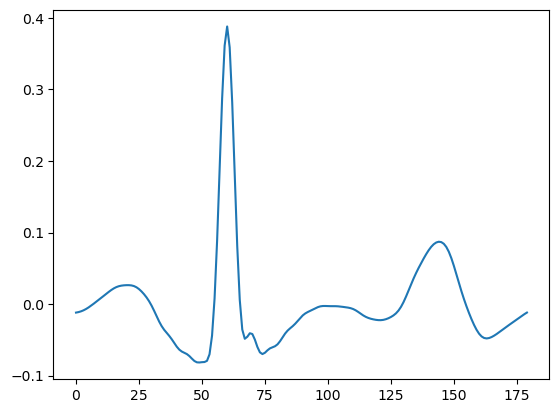

In [35]:
# Normalize the data and find the average characteristic heartbeat of each patient
normalized_templates=[]
patients_heartbeats = []
for i in range(len(templates_list)):
    normalized_templates.append(normalize(templates_list[i]))
    patients_heartbeats.append(sum(normalized_templates[i])/len(normalized_templates[i]))

plt.plot(patients_heartbeats[0])
plt.show()

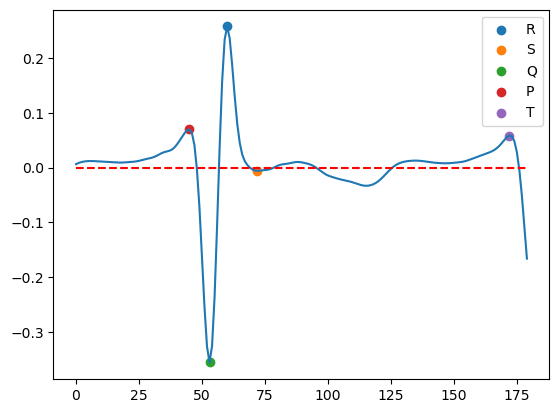

In [36]:
# Extarct all the peaks / Visualization
patient_current = patients_heartbeats[347]

# Find the peak
index = np.where(patient_current==max(patient_current))
R = index[0]

# First-half
first_half = patient_current[0:R[0]]
index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))

Q = index[0]
index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
P = index[0]

#Second half
second_half = patient_current[R[0]+1:] 
index = np.where(patient_current==min(second_half[0:30]))
S = index[0]

second_half = second_half[S[0]-R[0]+1:]
index = np.where(patient_current==max(second_half))
T = index[0] 

plt.plot(patient_current)
plt.scatter(R,patient_current[R],label='R')
plt.scatter(S,patient_current[S],label='S')
plt.scatter(Q,patient_current[Q],label='Q')
plt.scatter(P,patient_current[P],label='P')
plt.scatter(T,patient_current[T],label='T')
plt.plot(np.arange(0, 180),np.zeros(180), 'r--') 
plt.legend()
plt.show()

In [37]:
# Extarct all the peaks 
P_list=[]
Q_list=[]
R_list=[]
S_list=[]
T_list=[]

for i in range(len(patients_heartbeats)):

    patient_current = patients_heartbeats[i]

    # Find the peak
    index = np.where(patient_current==max(patient_current))
    R = index[0]

    # First-half
    first_half = patient_current[0:R[0]]
    index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))
    Q = index[0]
  
    index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
    P = index[0]

    #Second half
    second_half = patient_current[R[0]+1:] 
    index = np.where(patient_current==min(second_half[0:30]))
    S = index[0]

    second_half = second_half[S[0]-R[0]+1:]
    index = np.where(patient_current==max(second_half))
    T = index[0] 

    P_list.append(P[0])
    Q_list.append(Q[0])
    R_list.append(R[0])
    S_list.append(S[0])
    T_list.append(T[0])

In [38]:
# Intervals and Ratios of peaks
PR_list = []
QRS_list = []
ST_list = []

for i in range(len(P_list)):
    PR_list.append(R_list[i]-P_list[i])
    QRS_list.append(S_list[i]-Q_list[i])
    ST_list.append(T_list[i]-S_list[i])

PR_list = np.array(PR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)

C:\Users\wenxuan_song\AppData\Local\Temp\ipykernel_42944\3159975699.py:20: RuntimeWarning: divide by zero encountered in true_divide
  QRS_P_list= np.divide(QRS_list, P_list)


In [39]:
# Range, Mean and Median of amplitudes
max_A=[]
min_A=[]
mean_A=[]
median_A=[]

for i in range(len(patients_heartbeats)):
    
    patient_current = patients_heartbeats[i]

    max_A.append(max(patient_current))
    min_A.append(min(patient_current))
    mean_A.append(np.mean(patient_current))
    median_A.append(np.median(patient_current))

In [40]:
# Heart rates mean, median, variant and standard deviation
hr_mean=[]
hr_std=[]
hr_median=[]
hr_var = []
print(heart_rate_list[0].shape)
print(len(heart_rate_list))

for i in range(len(heart_rate_list)):
    d =np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))
    
hr_mean=np.nan_to_num(hr_mean, nan=0.0)
hr_std=np.nan_to_num(hr_std, nan=0.0)
hr_median=np.nan_to_num(hr_median, nan=0.0)
hr_var=np.nan_to_num(hr_var, nan=0.0)

(66,)
5117


C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: Run

In [41]:
# Timings of peaks mean, median, variant and standard deviation
ts_mean=[]
ts_std=[]
ts_median=[]
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)

In [42]:
# Timings of heart rates mean, median, variant and standard deviation
hr_ts_mean=[]
hr_ts_std=[]
hr_ts_median=[]
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)

In [43]:
# Peaks mean, median, variant, mode and standard deviation
peaks_mean=[]
peaks_std=[]
peaks_median=[]
peaks_mode=[]
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

C:\Users\wenxuan_song\AppData\Local\Temp\ipykernel_42944\246870434.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])


In [44]:
# Peaks differences mean, median, variant, mode and standard deviation
diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []

for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)

C:\Users\wenxuan_song\AppData\Local\Temp\ipykernel_42944\4050055541.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  diff_mode.append(np.mean(d)-stats.mode(d)[0])


In [45]:
# db2 coefficients
cA_list=[]
cD_list=[]

for i in range(len(patients_heartbeats)):
    cA, cD = pywt.dwt(patients_heartbeats[i], 'db2', mode='periodic')

    cA_list.append(cA)
    cD_list.append(cD)

In [46]:
# Energy of the signal
energy_list = []

for i in range(len(patients_heartbeats)):
    energy_list.append(np.sum(patients_heartbeats[i] ** 2))

In [47]:
# Prepare data
hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)
hr_ts_mean= np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std= np.array(hr_ts_std).reshape(-1,1)
hr_ts_median= np.array(hr_ts_median).reshape(-1,1)
hr_ts_var= np.array(hr_ts_var).reshape(-1,1)
ts_mean= np.array(ts_mean).reshape(-1,1)
ts_std= np.array(ts_std).reshape(-1,1)
ts_median= np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)
peaks_mean=np.array(peaks_mean).reshape(-1,1)
peaks_std=np.array(peaks_std).reshape(-1,1)
peaks_median=np.array(peaks_median).reshape(-1,1)
peaks_mode=np.array(peaks_mode).reshape(-1,1)
diff_mean=np.array(diff_mean).reshape(-1,1)
diff_std=np.array(diff_std).reshape(-1,1)
diff_median=np.array(diff_median).reshape(-1,1)
diff_mode=np.array(diff_mode).reshape(-1,1)
diff_var=np.array(diff_var).reshape(-1,1)
diff_dev=np.array(diff_dev).reshape(-1,1)
max_A=np.array(max_A).reshape(-1,1)
min_A=np.array(min_A).reshape(-1,1)
mean_A=np.array(mean_A).reshape(-1,1)
median_A=np.array(median_A).reshape(-1,1)
energy_list =np.array(energy_list).reshape(-1,1)
PR_list=np.array(PR_list).reshape(-1,1)
ST_list=np.array(ST_list).reshape(-1,1)
P_list=np.array(P_list).reshape(-1,1)
Q_list=np.array(Q_list).reshape(-1,1)
R_list=np.array(R_list).reshape(-1,1)
S_list=np.array(S_list).reshape(-1,1)
T_list=np.array(T_list).reshape(-1,1)
peaks_var=np.array(peaks_var).reshape(-1,1)

# Create data array of all the important extracted features
data=np.concatenate((fft_np, 
                     new_autocorr, 
                     ptp,
                     avg,
                     energy_list,
                     peaks_var,
                     peaks_mean, 
                     peaks_std, 
                     peaks_median, 
                     peaks_mode,   
                     T_list,
                     S_list,
                     R_list,
                     Q_list,
                     P_list,
                     ST_list,
                     QRS_list,
                     PR_list,
                     QRS_T_list,
                     QRS_P_list,
                     max_A-min_A,
                     mean_A,
                     median_A,
                     hr_std,
                     hr_mean,
                     hr_std,
                     hr_var,
                     hr_median,
                     hr_ts_mean,
                     hr_ts_std,
                     hr_ts_median,
                     hr_ts_var,
                     cD_list,
                     cA_list,
                     diff_dev, 
                     diff_var, 
                     diff_std,
                     diff_mode, 
                     diff_mean, 
                     diff_median,
                     ts_mean,
                     ts_std,
                     ts_median,
                     ts_var 
                     ), axis=1)
print (data.shape)

(5117, 238)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(data, dataset_y, test_size=0.20, random_state=42)

clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                 min_samples_split=60, min_samples_leaf=9, subsample=1.0,
                                 max_features=50, random_state=0)


print ('Training')
eval_set = [(x_test, y_test)]
clf.fit(x_train, y_train.ravel())
    
print ('Predicting')
predicted_labels = clf.predict(x_test)

print ('Scoring')
score = f1_score(y_test, predicted_labels, average='micro')

print('>%.3f' % score)

print ('Scoring')
confusion_matrix(y_test, predicted_labels)

Training
Predicting
Scoring
>0.824
Scoring


array([[559,   0,  34,   2],
       [  5,  60,  20,   1],
       [ 84,   8, 203,   7],
       [ 14,   0,   5,  22]], dtype=int64)

In [48]:
df = pd.read_csv('X_test.csv', header=0)
dataset_x_test = df.copy()
array = np.array(dataset_x_test)

dataset_x_test.pop("id")
dataset_x_test = np.array(dataset_x_test)

a = dataset_x_test
autocorr = []
ptp = []
avg = []
fft = []

for i in range(len(a)):
  h = a[i]
  h = h[~np.isnan(h)]
  h_series = pd.Series(h)
  corr = h_series.autocorr(lag=2)
  autocorr.append(corr)
  avg.append(np.average(h))
  ptp.append(np.ptp(h))
  f = np.fft.fft(h)
  array = f[0:800]
  n = 15
  indices = array.argsort()[-n:][::-1]
  fft.append(indices)

new_autocorr = np.transpose(np.array([autocorr]))
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft_np = np.array(fft)

to_pad = 17814
new_seq = []
for one_seq in dataset_x_test:
    one_seq = one_seq[~np.isnan(one_seq)]
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    to_concat = np.repeat(0, n)
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)
dataset_x_test = np.asarray(final_seq)

ts_list = []
filtered_list=[]
rpeaks_list=[]
templates_ts_list=[]
templates_list=[]
heart_rate_ts_list=[]
heart_rate_list=[]

for i in range(len(dataset_x_test)):
  print (i)
  ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = biosppy.signals.ecg.ecg(signal=dataset_x_test[i], sampling_rate=300.0, show=False)
  ts_list.append(ts)
  filtered_list.append(filtered)
  rpeaks_list.append(rpeaks)
  templates_ts_list.append(templates_ts)
  templates_list.append(templates)
  heart_rate_ts_list.append(heart_rate_ts)
  heart_rate_list.append(heart_rate)

######################################

normalized_templates=[]
patients_heartbeats = []
for i in range(len(templates_list)):
  normalized_templates.append(normalize(templates_list[i]))
  patients_heartbeats.append(sum(normalized_templates[i])/len(normalized_templates[i]))

P_list=[]
Q_list=[]
R_list=[]
S_list=[]
T_list=[]

for i in range(len(patients_heartbeats)):

  patient_current = patients_heartbeats[i]

  # Find the peak
  index = np.where(patient_current==max(patient_current))
  R = index[0]

  # First-half
  first_half = patient_current[0:R[0]]
  index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))
  Q = index[0]
  
  index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
  P = index[0]

  #Second half
  second_half = patient_current[R[0]+1:] 
  index = np.where(patient_current==min(second_half[0:30]))
  S = index[0]

  second_half = second_half[S[0]-R[0]+1:]
  index = np.where(patient_current==max(second_half))
  T = index[0] 

  P_list.append(P[0])
  Q_list.append(Q[0])
  R_list.append(R[0])
  S_list.append(S[0])
  T_list.append(T[0])

PR_list = []
QRS_list = []
ST_list = []

for i in range(len(P_list)):
  PR_list.append(R_list[i]-P_list[i])
  QRS_list.append(S_list[i]-Q_list[i])
  ST_list.append(T_list[i]-S_list[i])

  patient_current = patients_heartbeats[i]

PR_list = np.array(PR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)

max_A=[]
min_A=[]
mean_A=[]
median_A=[]

for i in range(len(patients_heartbeats)):
  patient_current = patients_heartbeats[i]
  max_A.append(max(patient_current))
  min_A.append(min(patient_current))
  mean_A.append(np.mean(patient_current))
  median_A.append(np.median(patient_current))

hr_mean=[]
hr_std=[]
hr_median=[]
hr_var = []

for i in range(len(heart_rate_list)):
    d =np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))

hr_mean=np.nan_to_num(hr_mean, nan=0.0)
hr_std=np.nan_to_num(hr_std, nan=0.0)
hr_median=np.nan_to_num(hr_median, nan=0.0)
hr_var=np.nan_to_num(hr_var, nan=0.0)

ts_mean=[]
ts_std=[]
ts_median=[]
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)

hr_ts_mean=[]
hr_ts_std=[]
hr_ts_median=[]
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)

peaks_mean=[]
peaks_std=[]
peaks_median=[]
peaks_mode=[]
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []

for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)

cA_list=[]
cD_list=[]

for i in range(len(patients_heartbeats)):
  cA, cD = pywt.dwt(patients_heartbeats[i], 'db2', mode='periodic')
  cA_list.append(cA)
  cD_list.append(cD)

energy_list = []

for i in range(len(patients_heartbeats)):
  energy_list.append(np.sum(patients_heartbeats[i] ** 2))

hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)
hr_ts_mean= np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std= np.array(hr_ts_std).reshape(-1,1)
hr_ts_median= np.array(hr_ts_median).reshape(-1,1)
hr_ts_var= np.array(hr_ts_var).reshape(-1,1)
ts_mean= np.array(ts_mean).reshape(-1,1)
ts_std= np.array(ts_std).reshape(-1,1)
ts_median= np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)
peaks_mean=np.array(peaks_mean).reshape(-1,1)
peaks_std=np.array(peaks_std).reshape(-1,1)
peaks_median=np.array(peaks_median).reshape(-1,1)
peaks_mode=np.array(peaks_mode).reshape(-1,1)
diff_mean=np.array(diff_mean).reshape(-1,1)
diff_std=np.array(diff_std).reshape(-1,1)
diff_median=np.array(diff_median).reshape(-1,1)
diff_mode=np.array(diff_mode).reshape(-1,1)
diff_var=np.array(diff_var).reshape(-1,1)
diff_dev=np.array(diff_dev).reshape(-1,1)
max_A=np.array(max_A).reshape(-1,1)
min_A=np.array(min_A).reshape(-1,1)
mean_A=np.array(mean_A).reshape(-1,1)
median_A=np.array(median_A).reshape(-1,1)
energy_list =np.array(energy_list).reshape(-1,1)
PR_list=np.array(PR_list).reshape(-1,1)
ST_list=np.array(ST_list).reshape(-1,1)
P_list=np.array(P_list).reshape(-1,1)
Q_list=np.array(Q_list).reshape(-1,1)
R_list=np.array(R_list).reshape(-1,1)
S_list=np.array(S_list).reshape(-1,1)
T_list=np.array(T_list).reshape(-1,1)
peaks_var=np.array(peaks_var).reshape(-1,1)

data_test=np.concatenate((fft_np, 
                     new_autocorr, 
                     ptp,
                     avg,
                     energy_list,
                     peaks_var,
                     peaks_mean, 
                     peaks_std, 
                     peaks_median, 
                     peaks_mode,   
                     T_list,
                     S_list,
                     R_list,
                     Q_list,
                     P_list,
                     ST_list,
                     QRS_list,
                     PR_list,
                     QRS_T_list,
                     QRS_P_list,
                     max_A-min_A,
                     mean_A,
                     median_A,
                     hr_std,
                     hr_mean,
                     hr_std,
                     hr_var,
                     hr_median,
                     hr_ts_mean,
                     hr_ts_std,
                     hr_ts_median,
                     hr_ts_var,
                     cD_list,
                     cA_list,
                     diff_dev, 
                     diff_var, 
                     diff_std,
                     diff_mode, 
                     diff_mean, 
                     diff_median,
                     ts_mean,
                     ts_std,
                     ts_median,
                     ts_var, ), axis=1)
print (data_test.shape)
#################################

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


C:\Users\wenxuan_song\AppData\Local\Temp\ipykernel_42944\358791749.py:130: RuntimeWarning: divide by zero encountered in true_divide
  QRS_P_list= np.divide(QRS_list, P_list)
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:254: Runtime

(3411, 238)


In [49]:
x_train = data
y_train = dataset_y

y_train = np.array(y_train) 
x_train= np.array(x_train) 

In [50]:
print(data.shape)
print(dataset_y.shape)
train_X, eval_X, train_Y, eval_Y = train_test_split(data, dataset_y, test_size=0.01, random_state=42)
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_eval = xgb.DMatrix(eval_X, label=eval_Y)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.2
param['gamma'] = 1.0
param['max_depth'] = 6
param['silent'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.9
param['min_child_weight'] = 20
param['num_class'] = 4


watchlist = [(xg_train, 'train'), (xg_eval, 'eval')]
num_round = 80
bst = xgb.train(param, 
                xg_train, 
                num_round, 
                watchlist, )
xg_test = xgb.DMatrix(data_test)
pred = bst.predict(xg_test)

(5117, 238)
(5117, 1)
[10:56:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:1.17428	eval-mlogloss:1.20088
[1]	train-mlogloss:1.02721	eval-mlogloss:1.07660
[2]	train-mlogloss:0.91468	eval-mlogloss:0.98339
[3]	train-mlogloss:0.82578	eval-mlogloss:0.90554


C:\Users\wenxuan_song\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[4]	train-mlogloss:0.75506	eval-mlogloss:0.86029
[5]	train-mlogloss:0.69941	eval-mlogloss:0.80925
[6]	train-mlogloss:0.65255	eval-mlogloss:0.77281
[7]	train-mlogloss:0.61226	eval-mlogloss:0.74052
[8]	train-mlogloss:0.57815	eval-mlogloss:0.71446
[9]	train-mlogloss:0.55000	eval-mlogloss:0.69740
[10]	train-mlogloss:0.52367	eval-mlogloss:0.68513
[11]	train-mlogloss:0.50258	eval-mlogloss:0.66812
[12]	train-mlogloss:0.48416	eval-mlogloss:0.66197
[13]	train-mlogloss:0.46735	eval-mlogloss:0.65423
[14]	train-mlogloss:0.45217	eval-mlogloss:0.64378
[15]	train-mlogloss:0.43706	eval-mlogloss:0.64442
[16]	train-mlogloss:0.42221	eval-mlogloss:0.64805
[17]	train-mlogloss:0.40996	eval-mlogloss:0.64218
[18]	train-mlogloss:0.39793	eval-mlogloss:0.64635
[19]	train-mlogloss:0.38608	eval-mlogloss:0.64352
[20]	train-mlogloss:0.37634	eval-mlogloss:0.64073
[21]	train-mlogloss:0.36839	eval-mlogloss:0.63756
[22]	train-mlogloss:0.36025	eval-mlogloss:0.63992
[23]	train-mlogloss:0.35129	eval-mlogloss:0.64184
[24]	t

In [60]:
print ('Training in the whole dataset')
clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=0)

clf.fit(x_train, y_train.ravel())
predictions = clf.predict(data_test)

Training in the whole dataset


In [79]:
print ('Training in the whole dataset')
clf1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=42)

clf1.fit(x_train, y_train.ravel())
predictions1 = clf1.predict(data_test)

Training in the whole dataset


In [ ]:
clf2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=700, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=245)

clf2.fit(x_train, y_train.ravel())
predictions2 = clf2.predict(data_test)

In [ ]:
clf3 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=5, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=35)

clf3.fit(x_train, y_train.ravel())
predictions3 = clf3.predict(data_test)

In [ ]:
predictions_combine = np.zeros((len(predictions),5))
predictions_combine[:,0] = pred
predictions_combine[:,1] = predictions
predictions_combine[:,2] = predictions1
predictions_combine[:,3] = predictions2
predictions_combine[:,4] = predictions3
#predictions_combine[:,5] = predictions4
#predictions_combine[:,6] = predictions5
#predictions_combine[:,7] = predictions6

pred_ensemble = np.zeros(len(predictions))
for i in range(len(predictions_combine)):
    int_version = predictions_combine[i,:].astype(int)
    print('int',int_version)
    print(np.bincount(int_version).argmax())
    pred_ensemble[i] = np.bincount(int_version).argmax()
               
print(pred_ensemble)

In [ ]:
f = open("submission_combine3.csv", "w")
f.write("id,y\n")
for i,x in enumerate(pred_ensemble):
    f.write("{},{}\n".format(i,pred_ensemble[i]))
f.close()

In [32]:


index = 0.0
with open('final_im2.txt', 'w') as f:
    f.write("%s\n" % "id,y")
    for predict in predictions:
        writing_str = str(index)+','+str(predict.item(0)*1.0)
        f.write("%s\n" % writing_str)
        index = index + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068


C:\Users\wenxuan_song\AppData\Local\Temp\ipykernel_6464\536907818.py:130: RuntimeWarning: divide by zero encountered in true_divide
  QRS_P_list= np.divide(QRS_list, P_list)
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\wenxuan_song\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeW

(3411, 238)
